In [14]:
"""Train a hyperbolic embedding model for hierarchical clustering."""

import argparse
import json
import logging
import os

import numpy as np
import torch
import torch.utils.data as data
from tqdm import tqdm
import matplotlib.pyplot as plt

import optim
from config import config_args
from datasets.hc_dataset import HCDataset
from datasets.loading import load_data
from utils.poincare import project
from model.hyphc import HypHC
from utils.metrics import dasgupta_cost
from utils.training import add_flags_from_config, get_savedir

import scipy

import msprime 

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float64)

ts = msprime.sim_ancestry(
    samples=10,
    population_size=10000,
    ploidy=1,
    recombination_rate=1E-8,
    sequence_length=1000,
    random_seed=seed,
    model=msprime.StandardCoalescent(duration=1E8)
)

ts = msprime.sim_mutations(
    ts, rate=1e-6, random_seed=seed, model="binary",
)

In [15]:
batch_size = 1024
epoch = 50
learning_rate = 1e-2
temperature = 5e-2
eval_every = 1
patience = 40
anneal_every = 10
anneal_factor = 0.5
init_size = 0.05
rank=4
init_size = 1e-3,
max_scale = 1 - 1e-3

In [16]:
# create ts dataset (n_sites, n_samples).T -> (n_samples, n_sites)
h = ts.genotype_matrix().T
# sample distance matrix (n_samples, n_samples)
similarities = scipy.spatial.distance.pdist(h)
similarities = scipy.spatial.distance.squareform(similarities)

dataset = HCDataset(h, ts.samples(), similarities, num_samples=ts.num_samples)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False, persistent_workers=True)

Generating all pairs subset


In [17]:

# create model
model = HypHC(dataset.n_nodes, rank, temperature, init_size, max_scale)

# create optimizer
optimizer = optim.RAdam(model.parameters(), learning_rate)

# train model
counter = 0
print("Start training")
for epoch in range(epoch):
    model.train()
    total_loss = 0.0
    with tqdm(total=len(dataloader), unit='ex') as bar:
        for step, (triple_ids, triple_similarities) in enumerate(dataloader):
            triple_ids = triple_ids
            triple_similarities = triple_similarities
            loss = model.loss(triple_ids, triple_similarities)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bar.update(1)
            bar.set_postfix(loss=f'{loss.item():.6f}')
            total_loss += loss
    total_loss = total_loss.item() / (step + 1.0)
    
    # anneal temperature
    if (epoch + 1) % anneal_every == 0:
        model.anneal_temperature(anneal_factor)
        print("Annealing temperature to: {}".format(model.temperature))
        for param_group in optimizer.param_groups:
            param_group['lr'] *= anneal_factor
            lr = param_group['lr']
        print("Annealing learning rate to: {}".format(lr))

# evaluation
model.eval()

Start training


100%|██████████| 1/1 [00:00<00:00, 274.78ex/s, loss=5.582714]


Annealing temperature to: 0.025
Annealing learning rate to: 0.005


100%|██████████| 1/1 [00:00<00:00, 377.36ex/s, loss=5.492879]


Annealing temperature to: 0.0125
Annealing learning rate to: 0.0025


100%|██████████| 1/1 [00:00<00:00, 359.72ex/s, loss=5.342561]


Annealing temperature to: 0.00625
Annealing learning rate to: 0.00125


100%|██████████| 1/1 [00:00<00:00, 303.78ex/s, loss=5.152053]


Annealing temperature to: 0.003125
Annealing learning rate to: 0.000625


100%|██████████| 1/1 [00:00<00:00, 312.91ex/s, loss=5.061295]

Annealing temperature to: 0.0015625
Annealing learning rate to: 0.0003125


HypHC(
  (embeddings): Embedding(10, 4)
)

In [18]:
tree = model.decode_tree(ts.samples(), fast_decoding=True)

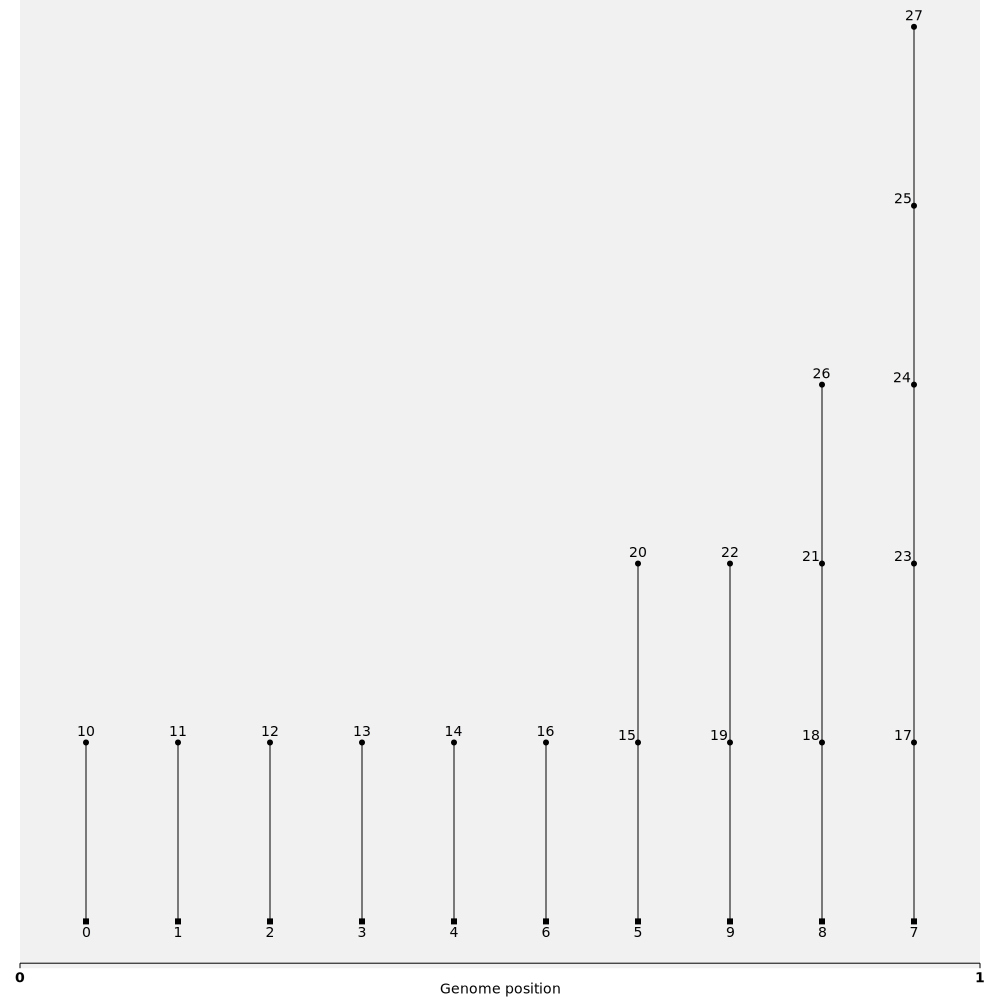

In [19]:
tree.draw_svg(size=(1000, 1000))